# Goal of the task

Analyse data extracted from a game. The final goal is to discriminate players that are bad, normal, or good performers. Process and visualise the
data, as well as cluster the players.(cite - Neuroengineer-task.pdf)


### Note:
1. All functions are in utils.py. 

2. Playground is the jupyter notebook I used for playing around with the data and brainstorming ideas. 

3. Task3_final is the jupyter notebook used for the demonstration of the finalised preprocessing steps and model performance 

Reading parquet files

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [ ]:
# Directory
file_path = '/home/nayanika/myelin-h/neuroengineering/Metadata-task3/n_back_data/n_back_data/data_43.parquet'

# Read Parquet file into a pandas DataFrame
df = pd.read_parquet(file_path)

# Display the DataFrame
# print(df)

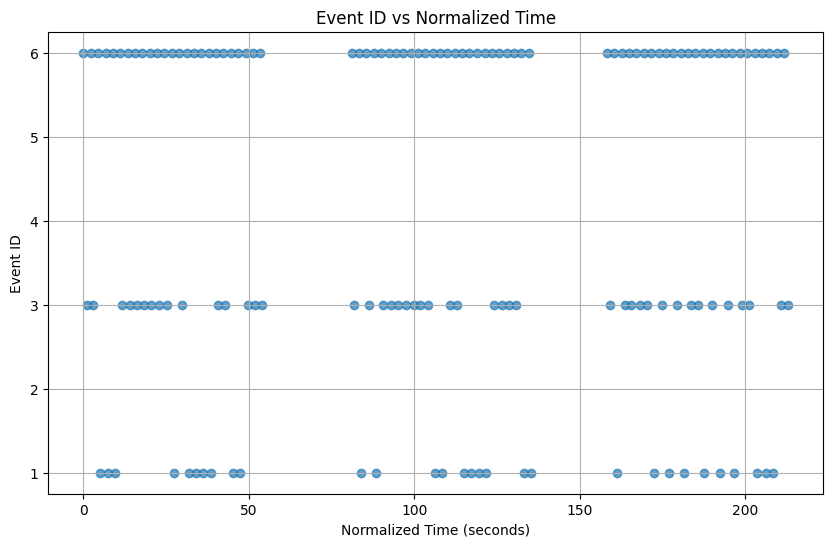

In [7]:
# normalize time with respect to the first timestamp
df['normalized_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

plt.figure(figsize=(10, 6))
plt.scatter(df['normalized_time'], df['event_id'], marker='o', alpha=0.7)
plt.xlabel('Normalized Time (seconds)')
plt.ylabel('Event ID')
plt.title('Event ID vs Normalized Time')
plt.grid(True)
plt.show()


In [30]:
# Dircetory
parquet_directory = '/home/nayanika/myelin-h/neuroengineering/Metadata-task3/n_back_data/n_back_data/'

# List all Parquet files in the directory
parquet_files = [file for file in os.listdir(parquet_directory) if file.endswith('.parquet')]
parquet_files = sorted(parquet_files)

# list to store results from each file
list_of_hit_rate = []
list_of_miss_rate = []
list_of_FA_rate = []
list_of_hit_latencies = []
list_of_FA_latencies = []
ID_list = []

# extract features from each file
for parquet_file in parquet_files:

    # exclude patient 40
    if parquet_file == 'data_42.parquet':
        pass
    else:
        
        file_path = os.path.join(parquet_directory, parquet_file)
        df = pd.read_parquet(file_path)

        df['normalized_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
        df['group'] = pd.cut(df['i'], bins=[-1, 49, 101, 155], labels=['Group 1', 'Group 2', 'Group 3'])

        desired_event_ids = [1, 2, 3, 4, 5, 6]

        # Count the occurrences of each event ID within each group and fill missing values with 0
        group_counts = df.groupby(['group', 'event_id']).size().unstack(fill_value=0)
        group_counts = group_counts.reindex(columns=desired_event_ids, fill_value=0)

        # print(group_counts)

        hit_rate = (group_counts.loc[:, 1]+ group_counts.loc[:, 3])/group_counts.loc[:, 6]
        FA_rate = (group_counts.loc[:, 2]+ group_counts.loc[:, 4])/group_counts.loc[:, 6]
        miss_rate = (group_counts.loc[:, 5])/group_counts.loc[:, 6]

        # Calculate the time difference between consecutive rows for latencies
        df['time_difference'] = df['normalized_time'].diff()
    
        latencies = df.groupby(['event_id', 'group'])['time_difference'].mean().reset_index()
        hit_latencies = df[df['event_id'].isin([1, 3])].groupby(['group'])['time_difference'].mean().reset_index().set_index('group')
        FA_latencies = df[df['event_id'].isin([2, 4])].groupby(['group'])['time_difference'].mean().reset_index().set_index('group')

        list_of_hit_rate.append(hit_rate)
        list_of_FA_rate.append(FA_rate)
        list_of_miss_rate.append(miss_rate)
        list_of_hit_latencies.append(hit_latencies)
        list_of_FA_latencies.append(FA_latencies)
        ID_list.append(parquet_file.split('.')[0])


# Combine results from all files into a single DataFrame
hit_rate_all = pd.concat(list_of_hit_rate, axis=1, ignore_index=True)
FA_rate_all = pd.concat(list_of_FA_rate, axis=1,ignore_index=True)
miss_rate_all = pd.concat(list_of_miss_rate, axis=1,ignore_index=True)
hit_latencies_all = pd.concat(list_of_hit_latencies, axis=1, ignore_index=True)
FA_latencies_all = pd.concat(list_of_FA_latencies, axis=1, ignore_index=True)

# print(hit_rate_all)
# print(hit_latencies_all)

# all_features = pd.concat([hit_rate_all, FA_rate_all, miss_rate_all, hit_latencies_all, FA_latencies_all], ignore_index=True)
all_features = pd.concat([hit_rate_all, FA_rate_all, miss_rate_all, hit_latencies_all], ignore_index=True)

# hit, FA and miss rates only
subset1_features = pd.concat([hit_rate_all, FA_rate_all, miss_rate_all], ignore_index=True)

# hit rate only
subset2_features = pd.concat([hit_rate_all], ignore_index=True)

print(ID_list)

# print(all_features)

['data_0', 'data_1', 'data_10', 'data_11', 'data_12', 'data_13', 'data_14', 'data_15', 'data_16', 'data_17', 'data_18', 'data_19', 'data_2', 'data_20', 'data_21', 'data_22', 'data_23', 'data_24', 'data_25', 'data_26', 'data_27', 'data_28', 'data_29', 'data_3', 'data_30', 'data_31', 'data_32', 'data_33', 'data_34', 'data_35', 'data_36', 'data_37', 'data_38', 'data_39', 'data_4', 'data_40', 'data_41', 'data_43', 'data_44', 'data_45', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9']


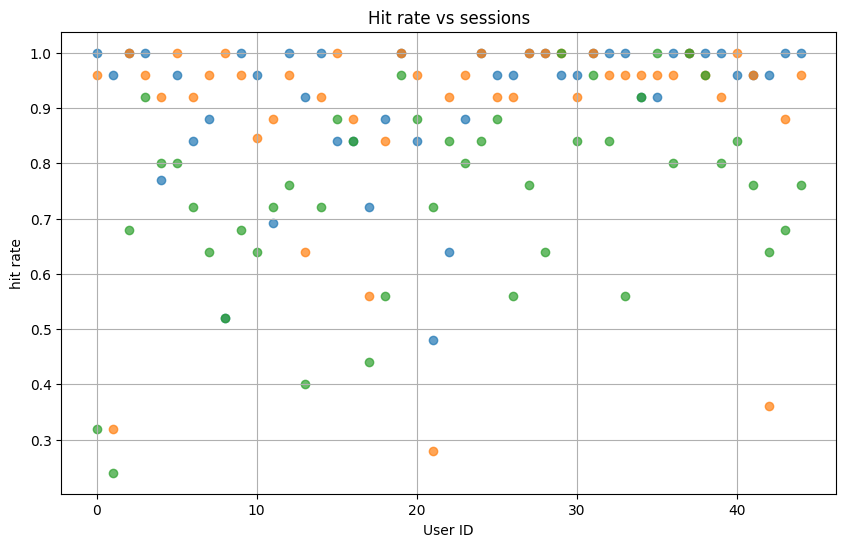

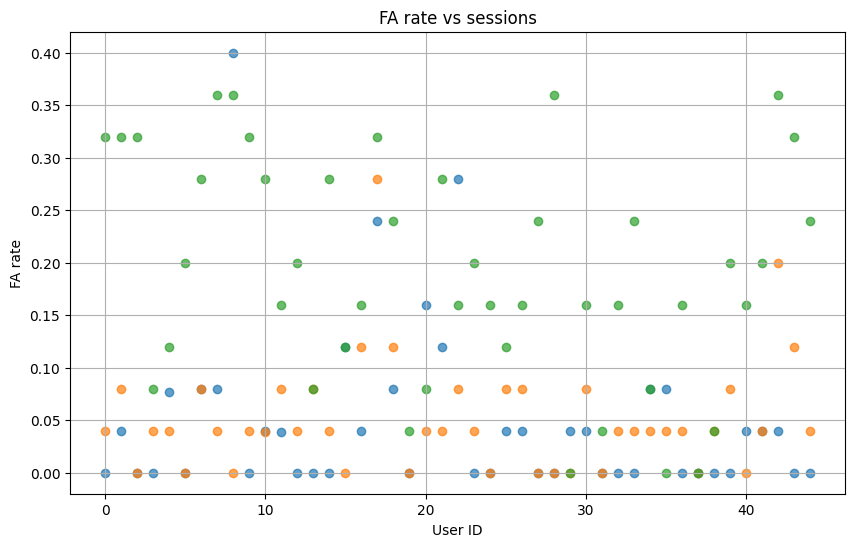

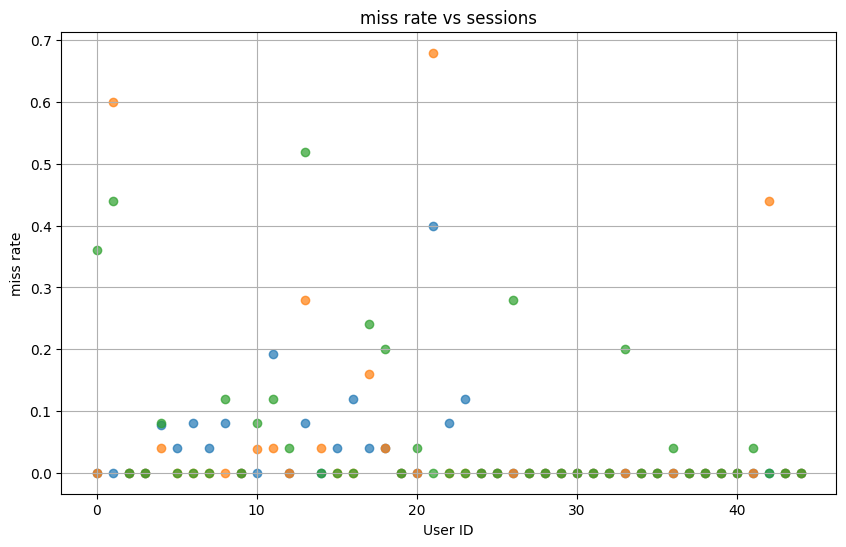

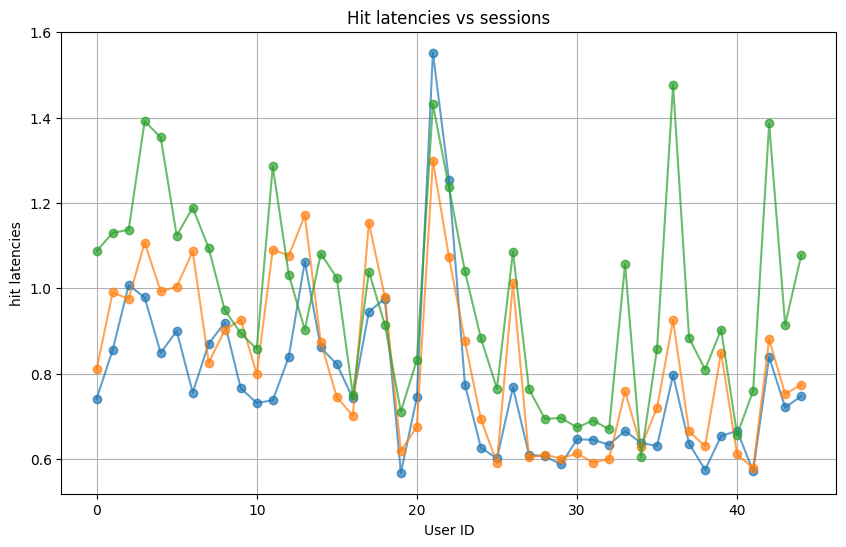

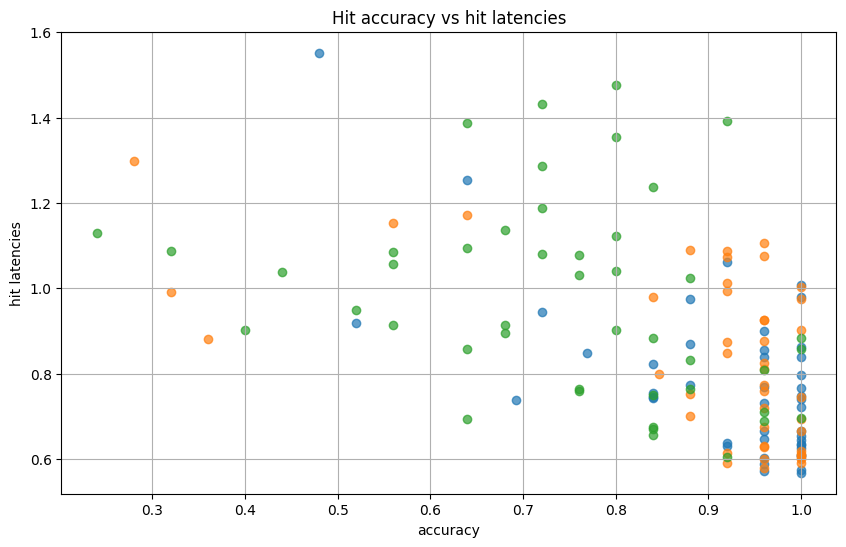

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(45), all_features.loc[0,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[1,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[2,:], marker='o', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('hit rate')
plt.title('Hit rate vs sessions')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(45), all_features.loc[3,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[4,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[5,:], marker='o', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('FA rate')
plt.title('FA rate vs sessions')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(45), all_features.loc[6,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[7,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[8,:], marker='o', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('miss rate')
plt.title('miss rate vs sessions')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(45), all_features.loc[9,:], marker='o', alpha=0.7)
plt.plot(np.arange(45), all_features.loc[10,:], marker='o', alpha=0.7)
plt.plot(np.arange(45), all_features.loc[11,:], marker='o', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('hit latencies')
plt.title('Hit latencies vs sessions')
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(np.arange(45), all_features.loc[12,:], marker='o', alpha=0.7)
# plt.plot(np.arange(45), all_features.loc[13,:], marker='o', alpha=0.7)
# plt.plot(np.arange(45), all_features.loc[14,:], marker='o', alpha=0.7)
# plt.xlabel('User ID')
# plt.ylabel('FA latencies')
# plt.title('FA latencies vs sessions')
# plt.grid(True)
# plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(all_features.loc[0,:], all_features.loc[9,:], marker='o', alpha=0.7)
plt.scatter(all_features.loc[1,:], all_features.loc[10,:], marker='o', alpha=0.7)
plt.scatter(all_features.loc[2,:], all_features.loc[11,:], marker='o', alpha=0.7)
plt.xlabel('accuracy')
plt.ylabel('hit latencies')
plt.title('Hit accuracy vs hit latencies')
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.scatter(all_features.loc[3,:], all_features.loc[12,:], marker='o', alpha=0.7)
# plt.scatter(all_features.loc[4,:], all_features.loc[13,:], marker='o', alpha=0.7)
# plt.scatter(all_features.loc[5,:], all_features.loc[14,:], marker='o', alpha=0.7)
# plt.xlabel('FA')
# plt.ylabel('FA latencies')
# plt.title('FA accuracy vs FA latencies')
# plt.grid(True)
# plt.show()

In [11]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

num_clusters = 3

def plot_silhouette(df, clusters):

    silhouette_avg = silhouette_score(df, clusters)
    sample_silhouette_values = silhouette_samples(df, clusters)


    print(f"Silhouette Score: {silhouette_avg}")

    # Score per sample    
    y_lower = 10
    for j in range(num_clusters):
        
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == j]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(j) / num_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))
        y_lower = y_upper + 10

    plt.title(f'Number of clusters: {num_clusters}\nSilhouette Score: {silhouette_avg:.2f}', fontsize=12)
    plt.xlabel('Silhouette Score')
    plt.ylabel('Cluster Label')

#### k means -  all features

/home/nayanika/anaconda3/envs/myelin-h/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


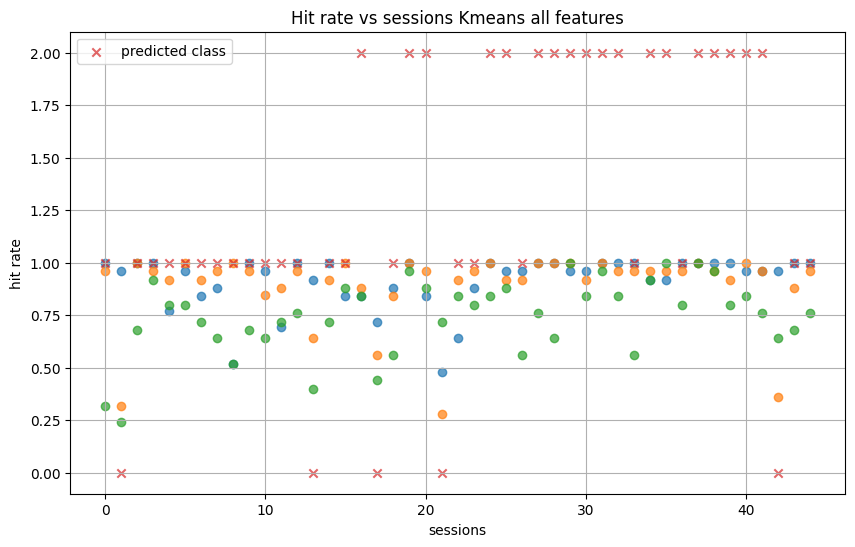

Silhouette Score: 0.6447081180886387


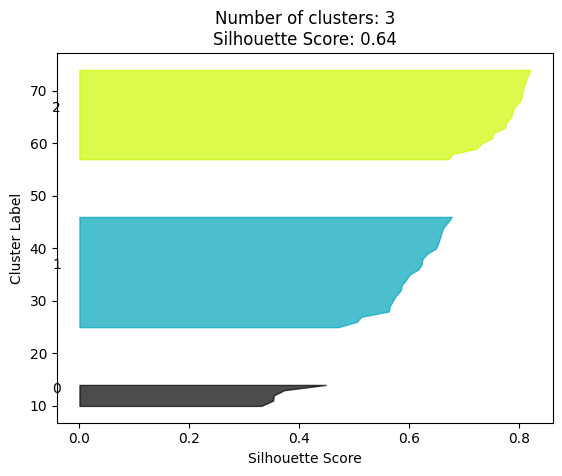

In [15]:
df_transposed = all_features.T

# KMeans model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
clusters_km = kmeans_model.fit_predict(df_transposed)

df_transposed['Cluster'] = clusters_km

# print(df_transposed)    


plt.figure(figsize=(10, 6))
plt.scatter(np.arange(45), all_features.loc[0,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[1,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[2,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), clusters_km, marker='x', alpha=0.7, label= 'predicted class')
plt.xlabel('User ID')
plt.ylabel('hit rate')
plt.title('Hit rate vs sessions Kmeans all features')
plt.grid(True)
plt.legend()
plt.show()

plot_silhouette(df_transposed, clusters_km)

#### k means - Hit rate, FA rate and miss rate only

/home/nayanika/anaconda3/envs/myelin-h/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


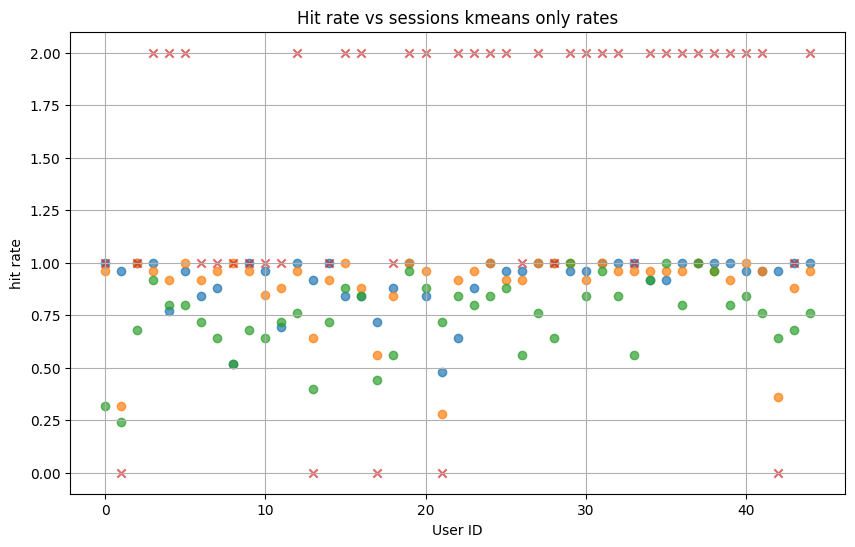

Silhouette Score: 0.772097484777256
similarity between all feature vs rate only features predictions: 0.7777777777777778
[1.         0.59090909 0.94444444]


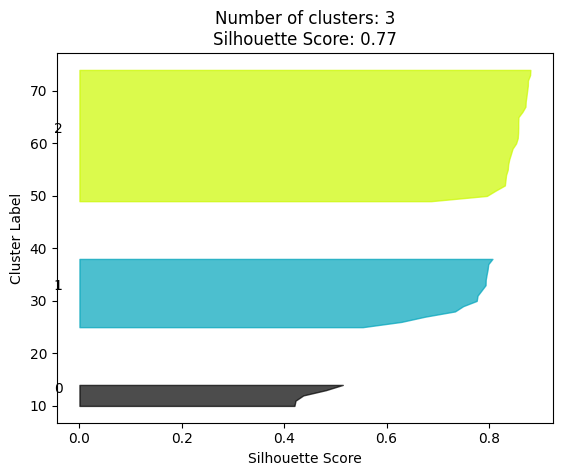

In [25]:
df_transposed = subset1_features.T

# KMeans model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
clusters_km_subset1= kmeans_model.fit_predict(df_transposed)

df_transposed['Cluster'] = clusters_km_subset1

# print(df_transposed)    

# Mapping to ensure consistency of classes
value_mapping = {2: 1, 1: 0, 0: 2}
clusters_km_subset1= np.array([value_mapping[value] for value in clusters_km_subset1])

# print(clusters_km_subset1)

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(45), subset1_features.loc[0,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), subset1_features.loc[1,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), subset1_features.loc[2,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), clusters_km_subset1, marker='x', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('hit rate')
plt.title('Hit rate vs sessions kmeans only rates')
plt.grid(True)
plt.show()

plot_silhouette(df_transposed, clusters_km_subset1)

similarity = clusters_km == clusters_km_subset1
print(f'similarity between all feature vs rate only features predictions: {sum(similarity)/len(clusters_km)}')
same_cluster_frequency = np.unique(clusters_km[similarity], return_counts=True)[1]/np.unique(clusters_km, return_counts=True)[1]
print(same_cluster_frequency)

#### K means - hit rate only

/home/nayanika/anaconda3/envs/myelin-h/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


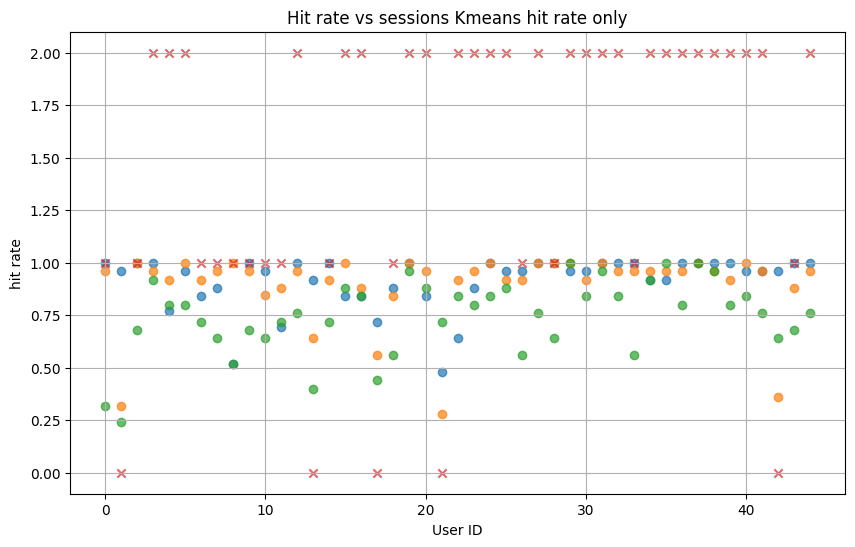

Silhouette Score: 0.8254257262817238
1.0
[1. 1. 1.]


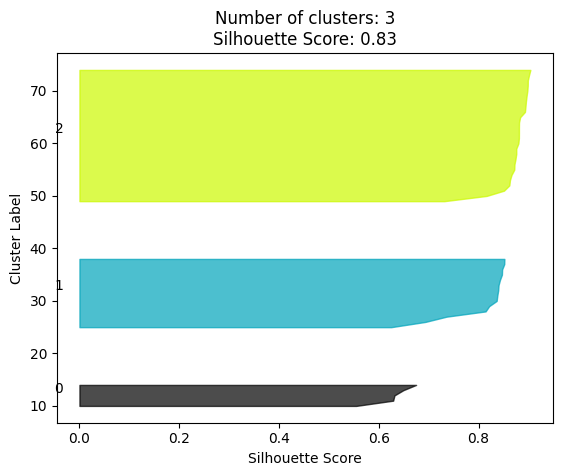

In [24]:
df_transposed = subset2_features.T


# KMeans model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
clusters_km_subset2 = kmeans_model.fit_predict(df_transposed)

df_transposed['Cluster'] = clusters_km_subset2

# print(df_transposed)   
 
# Mapping to ensure consistency of classes
value_mapping = {2: 1, 1: 0, 0: 2}
clusters_km_subset2= np.array([value_mapping[value] for value in clusters_km_subset2])

# print(clusters_km_subset2)

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(45), all_features.loc[0,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[1,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[2,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), clusters_km_subset2, marker='x', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('hit rate')
plt.title('Hit rate vs sessions Kmeans hit rate only')
plt.grid(True)
plt.show()

plot_silhouette(df_transposed, clusters_km_subset2)

similarity = clusters_km_subset2 == clusters_km_subset1
print(sum(similarity)/len(clusters_km_subset2))
same_cluster_frequency = np.unique(clusters_km_subset2[similarity], return_counts=True)[1]/np.unique(clusters_km_subset2, return_counts=True)[1]
print(same_cluster_frequency)

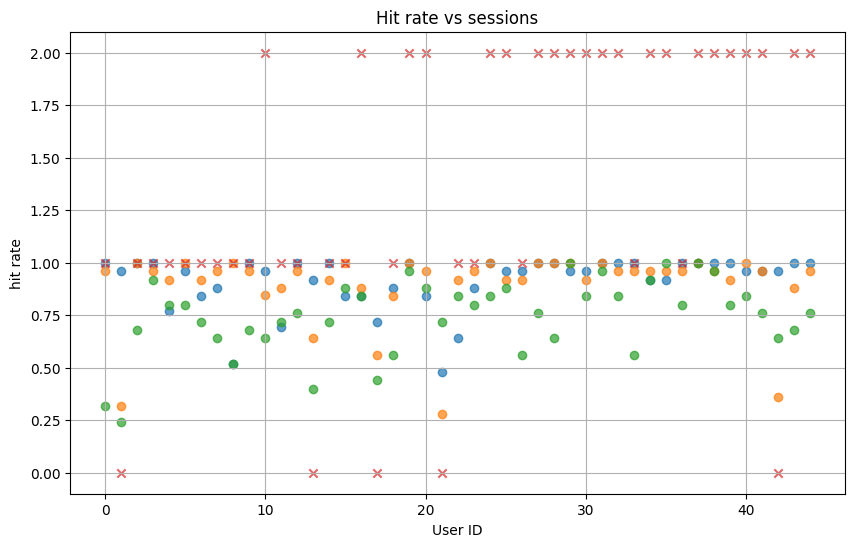

Silhouette Score: 0.6933148657839379
with kmeans:0.9333333333333333
[1.         0.86363636 1.        ]
with kmeans and subset of features:0.7555555555555555
[1.         0.78571429 0.69230769]


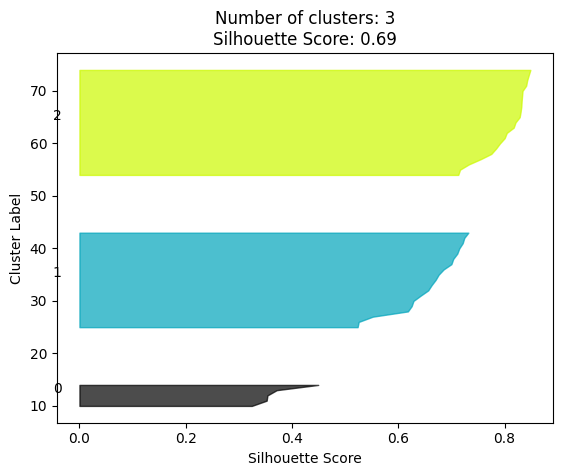

In [23]:
df_transposed = all_features.T

# GaussianMixture model
gmm_model = GaussianMixture(n_components=num_clusters, random_state=42)
clusters_gmm = gmm_model.fit_predict(df_transposed)

df_transposed['Cluster'] = clusters_gmm

# print(df_transposed)

# Mapping
value_mapping = {2: 1, 1: 0, 0: 2}
clusters_gmm= np.array([value_mapping[value] for value in clusters_gmm])

# print(clusters_gmm)

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(45), all_features.loc[0,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[1,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[2,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), clusters_gmm, marker='x', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('hit rate')
plt.title('Hit rate vs sessions')
plt.grid(True)
plt.show()

plot_silhouette(df_transposed, clusters_gmm)

similarity = clusters_km == clusters_gmm
print(f'with kmeans:{sum(similarity)/len(clusters_km)}')
same_cluster_frequency = np.unique(clusters_km[similarity], return_counts=True)[1]/np.unique(clusters_km, return_counts=True)[1]
print(same_cluster_frequency)

similarity = clusters_km_subset1 == clusters_gmm
print(f'with kmeans and subset of features:{sum(similarity)/len(clusters_km_subset1)}')
same_cluster_frequency = np.unique(clusters_km_subset1[similarity], return_counts=True)[1]/np.unique(clusters_km_subset1, return_counts=True)[1]
print(same_cluster_frequency)


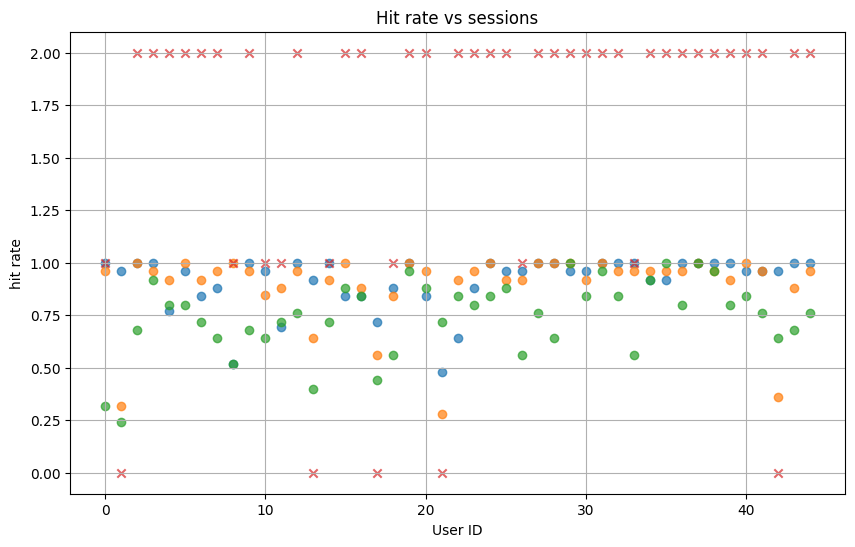

Silhouette Score: 0.2246879329193227
with kmeans:0.6888888888888889
[1.         0.36363636 1.        ]
with kmeans and subset of features:0.8666666666666667
[1.         0.57142857 1.        ]


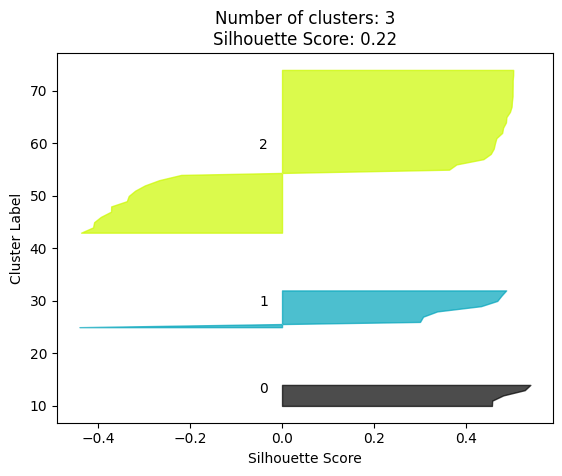

In [26]:
df_transposed = subset1_features.T

# GaussianMixture model
gmm_model = GaussianMixture(n_components=num_clusters, random_state=4)
clusters_gmm_subset1 = gmm_model.fit_predict(df_transposed)

df_transposed['Cluster'] = clusters_gmm

# print(df_transposed)

# Mapping
value_mapping = {2: 0, 1: 2, 0: 1}
clusters_gmm_subset1= np.array([value_mapping[value] for value in clusters_gmm_subset1])

# print(clusters_gmm_subset1)

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(45), all_features.loc[0,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[1,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[2,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), clusters_gmm_subset1, marker='x', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('hit rate')
plt.title('Hit rate vs sessions')
plt.grid(True)
plt.show()

plot_silhouette(df_transposed, clusters_gmm_subset1)


similarity = clusters_km == clusters_gmm_subset1
print(f'with kmeans:{sum(similarity)/len(clusters_km)}')
same_cluster_frequency = np.unique(clusters_km[similarity], return_counts=True)[1]/np.unique(clusters_km, return_counts=True)[1]
print(same_cluster_frequency)

similarity = clusters_km_subset1 == clusters_gmm_subset1
print(f'with kmeans and subset of features:{sum(similarity)/len(clusters_km_subset1)}')
same_cluster_frequency = np.unique(clusters_km_subset1[similarity], return_counts=True)[1]/np.unique(clusters_km_subset1, return_counts=True)[1]
print(same_cluster_frequency)

/home/nayanika/anaconda3/envs/myelin-h/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


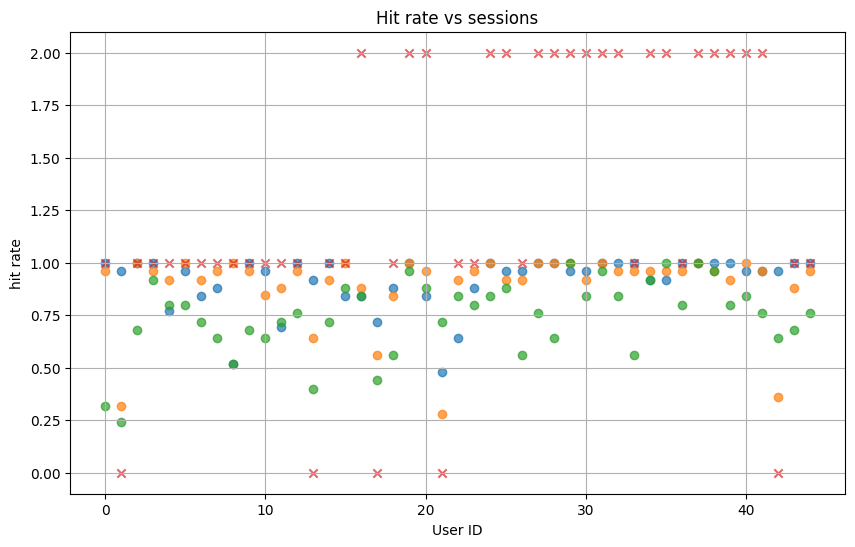

Silhouette Score: 0.6982772625247222
with kmeans:1.0
[1. 1. 1.]
with kmeans and subset of features:0.7777777777777778
[1.         0.92857143 0.65384615]


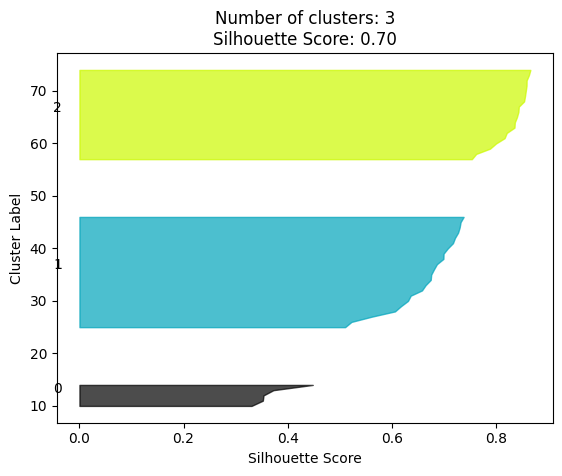

In [29]:
# pca and then k means

df_transposed = all_features.T

# Perform PCA
num_components = df_transposed.shape[1] 
pca = PCA(n_components=num_components)
df_pca = pca.fit_transform(df_transposed)

# print(pca.explained_variance_ratio_)
# print(pca.components_)

# KMeans model
num_clusters = 3  # Adjust as needed
kmeans_model = KMeans(n_clusters=num_clusters, random_state=4)
clusters_km_pca = kmeans_model.fit_predict(df_pca)

df_transposed['Cluster'] = clusters_km_pca

# Mapping
value_mapping = {2: 2, 1: 0, 0: 1}
clusters_km_pca= np.array([value_mapping[value] for value in clusters_km_pca])

# print(clusters_km_pca)

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(45), all_features.loc[0,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[1,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[2,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), clusters_km_pca, marker='x', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('hit rate')
plt.title('Hit rate vs sessions')
plt.grid(True)
plt.show()

plot_silhouette(df_transposed, clusters_km_pca)

similarity = clusters_km == clusters_km_pca
print(f'with kmeans:{sum(similarity)/len(clusters_km)}')
same_cluster_frequency = np.unique(clusters_km[similarity], return_counts=True)[1]/np.unique(clusters_km, return_counts=True)[1]
print(same_cluster_frequency)

similarity = clusters_km_subset1 == clusters_km_pca
print(f'with kmeans and subset of features:{sum(similarity)/len(clusters_km_subset1)}')
same_cluster_frequency = np.unique(clusters_km_subset1[similarity], return_counts=True)[1]/np.unique(clusters_km_subset1, return_counts=True)[1]
print(same_cluster_frequency)


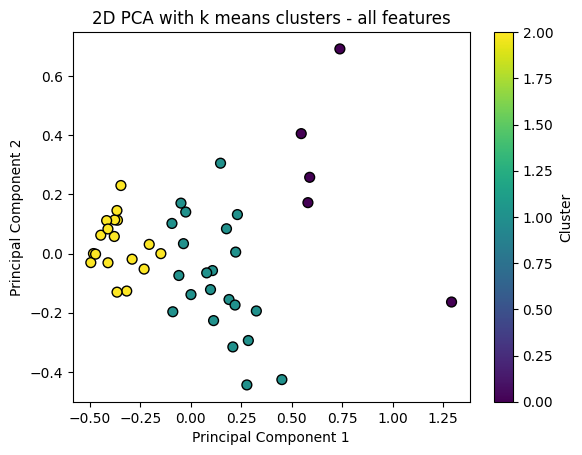

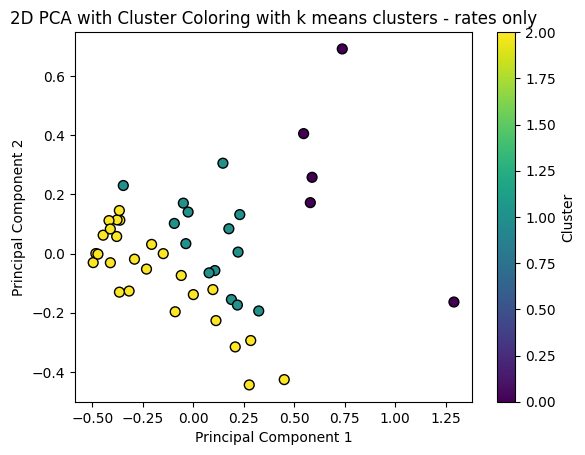

In [99]:
plot_PCA = pd.DataFrame({'PC1': df_pca[:, 0], 'PC2': df_pca[:, 1], 'Cluster': clusters_km_pca})

# Plotting
plt.scatter(plot_PCA['PC1'], plot_PCA['PC2'], c=plot_PCA['Cluster'], cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA with k means clusters - all features')
plt.colorbar(label='Cluster')
plt.show()

# Plotting
plt.scatter(plot_PCA['PC1'], plot_PCA['PC2'], c=clusters_km_subset1, cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA with Cluster Coloring with k means clusters - rates only')
plt.colorbar(label='Cluster')
plt.show()

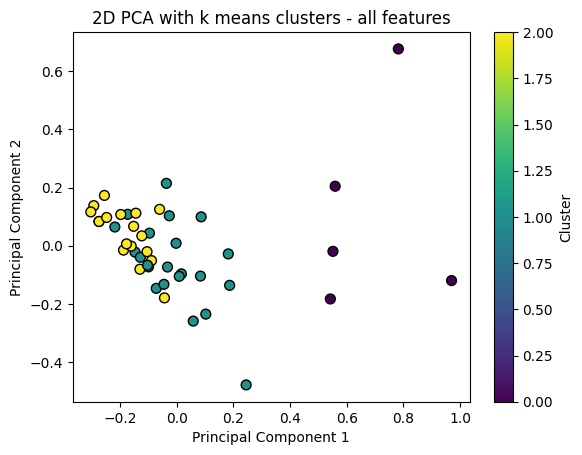

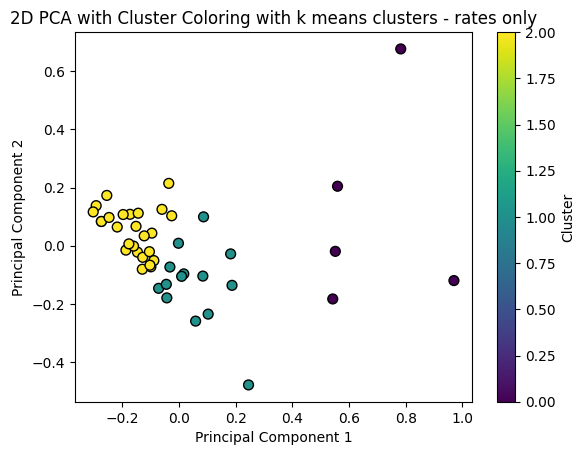

In [101]:
# Transpose the DataFrame to have samples as rows and features as columns
df_transposed = subset1_features.T

# Specify the number of principal components
num_components = df_transposed.shape[1]  # Adjust as needed

# Perform PCA
pca = PCA(n_components=num_components)
df_pca = pca.fit_transform(df_transposed)

# print(pca.explained_variance_ratio_)
# print(pca.components_)

# Create a DataFrame for plotting
plot_PCA = pd.DataFrame({'PC1': df_pca[:, 0], 'PC2': df_pca[:, 1], 'Cluster': clusters_km_pca})

# Plotting
plt.scatter(plot_PCA['PC1'], plot_PCA['PC2'], c=plot_PCA['Cluster'], cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA with k means clusters - all features')
plt.colorbar(label='Cluster')
plt.show()

# Plotting
plt.scatter(plot_PCA['PC1'], plot_PCA['PC2'], c=clusters_km_subset1, cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA with Cluster Coloring with k means clusters - rates only')
plt.colorbar(label='Cluster')
plt.show()

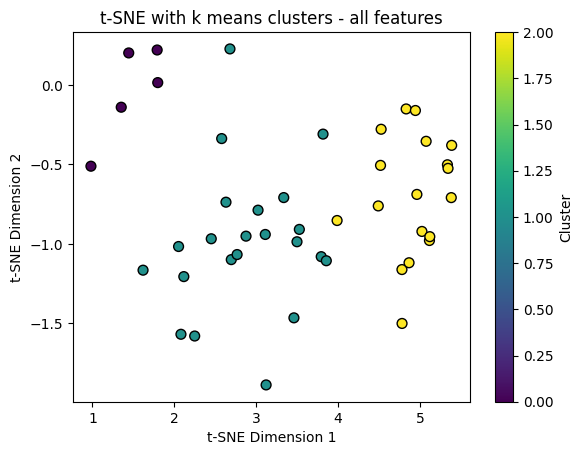

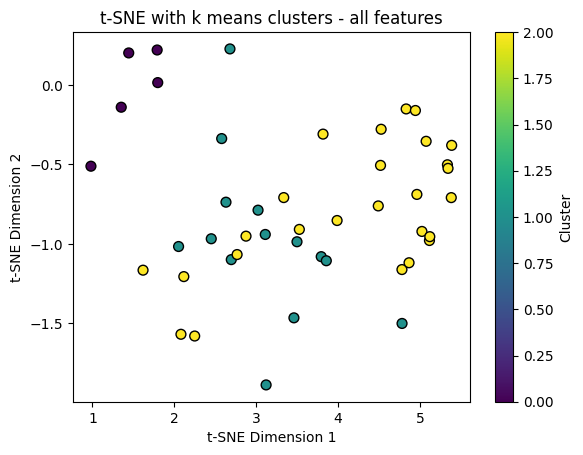

In [ ]:
from sklearn.manifold import TSNE

# Transpose the DataFrame to have samples as rows and features as columns
df_transposed = all_features.T

# Specify the number of dimensions in the embedded space
num_dimensions = 2  # Adjust as needed

# Instantiate the t-SNE model
tsne_model = TSNE(n_components=num_dimensions, random_state=42)

# Fit the model to your data
tsne_result = tsne_model.fit_transform(df_transposed)

# Create a DataFrame for plotting
plot_PCA = pd.DataFrame({'Dimension 1': tsne_result[:, 0], 'Dimension 2': tsne_result[:, 1], 'Cluster': clusters_km})

# Plotting
plt.scatter(plot_PCA['Dimension 1'], plot_PCA['Dimension 2'], c=plot_PCA['Cluster'], cmap='viridis', edgecolors='k', s=50)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE with k means clusters - all features')
plt.colorbar(label='Cluster')
plt.show()

# Plotting
plt.scatter(plot_PCA['Dimension 1'], plot_PCA['Dimension 2'], c=clusters_km_subset1, cmap='viridis', edgecolors='k', s=50)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE with k means clusters - all features')
plt.colorbar(label='Cluster')
plt.show()


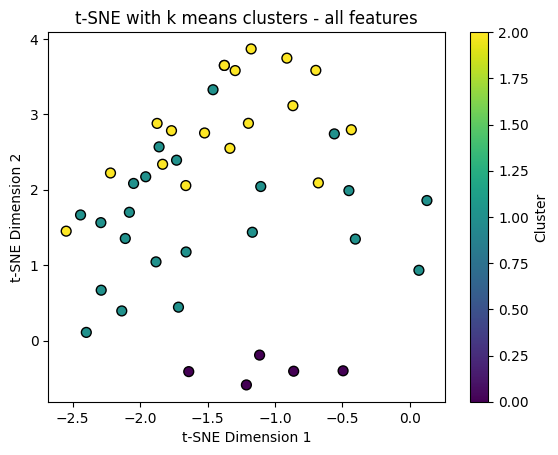

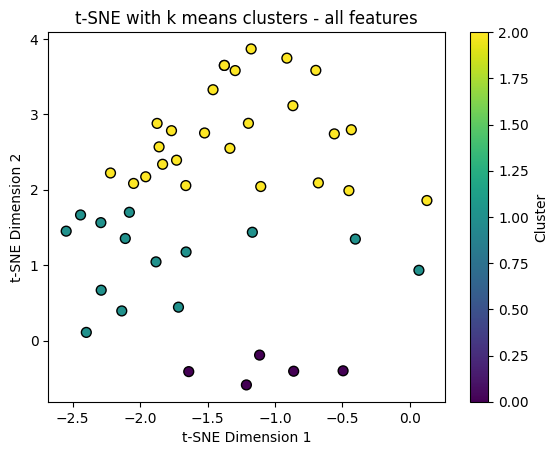

In [98]:
from sklearn.manifold import TSNE

# Transpose the DataFrame to have samples as rows and features as columns
df_transposed = subset1_features.T

# Specify the number of dimensions in the embedded space
num_dimensions = 2  # Adjust as needed

# Instantiate the t-SNE model
tsne_model = TSNE(n_components=num_dimensions, random_state=42)

# Fit the model to your data
tsne_result = tsne_model.fit_transform(df_transposed)

# Create a DataFrame for plotting
plot_PCA = pd.DataFrame({'Dimension 1': tsne_result[:, 0], 'Dimension 2': tsne_result[:, 1], 'Cluster': clusters_km})

# Plotting
plt.scatter(plot_PCA['Dimension 1'], plot_PCA['Dimension 2'], c=plot_PCA['Cluster'], cmap='viridis', edgecolors='k', s=50)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE with k means clusters - all features')
plt.colorbar(label='Cluster')
plt.show()

# Plotting
plt.scatter(plot_PCA['Dimension 1'], plot_PCA['Dimension 2'], c=clusters_km_subset1, cmap='viridis', edgecolors='k', s=50)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE with k means clusters - all features')
plt.colorbar(label='Cluster')
plt.show()


In [120]:
data = {'k means all features': clusters_km,
  'k means pca': clusters_km_pca,
  'k means rate only': clusters_km_subset1,
  'gmm all features': clusters_gmm, 
  'k means hit rate only':clusters_km_subset2}

all_clusters = pd.DataFrame(data)

# all_clusters['cluster ID'] = 

all_clusters.head

<bound method NDFrame.head of     k means all features  k means pca  k means rate only  gmm all features  \
0                      1            1                  1                 1   
1                      0            0                  0                 0   
2                      1            1                  1                 1   
3                      1            1                  2                 1   
4                      1            1                  2                 1   
5                      1            1                  2                 1   
6                      1            1                  1                 1   
7                      1            1                  1                 1   
8                      1            1                  1                 1   
9                      1            1                  1                 1   
10                     1            1                  1                 2   
11                     1          

In [63]:
# Specify the directory containing your Parquet files
parquet_directory = '/home/nayanika/myelin-h/neuroengineering/Metadata-task3/n_back_data/n_back_data/'

# List all Parquet files in the directory
parquet_files = [file for file in os.listdir(parquet_directory) if file.endswith('.parquet')]
parquet_files = sorted(parquet_files)

# Container to store results from each file
list_of_hit_rate = []
list_of_miss_rate = []
list_of_FA_rate = []
list_of_hit_latencies = []
list_of_FA_latencies = []

# Loop through each Parquet file
for parquet_file in parquet_files:

    # exclude patient 40
    if parquet_file == 'data_50.parquet': # rqandom file number so that everything is included
        pass
    else:
        # Read the Parquet file into a DataFrame
        file_path = os.path.join(parquet_directory, parquet_file)
        df = pd.read_parquet(file_path)

        df['normalized_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
        
        # Perform your DataFrame operations here
        # Assuming df is your DataFrame with 'event_id' column
        # Create a new column 'group' to represent the groups of 50 rows
        df['group'] = pd.cut(df['i'], bins=[-1, 49, 101, 155], labels=['Group 1', 'Group 2', 'Group 3'])

        # Define the event_id values you want to include
        desired_event_ids = [1, 2, 3, 4, 5, 6]

        # Count the occurrences of each event ID within each group and fill missing values with 0
        group_counts = df.groupby(['group', 'event_id']).size().unstack(fill_value=0)

        # Reindex the DataFrame to include all desired event_id values and fill missing values with 0
        group_counts = group_counts.reindex(columns=desired_event_ids, fill_value=0)

        # Display the resulting DataFrame
        # print(group_counts)

        hit_rate = (group_counts.loc[:, 1]+ group_counts.loc[:, 3])/group_counts.loc[:, 6]
        FA_rate = (group_counts.loc[:, 2]+ group_counts.loc[:, 4])/group_counts.loc[:, 6]
        miss_rate = (group_counts.loc[:, 5])/group_counts.loc[:, 6]

        # Calculate the time difference between consecutive rows
        df['time_difference'] = df['normalized_time'].diff()
        
        # Store results in a container (e.g., append to a list)
        latencies = df.groupby(['event_id', 'group'])['time_difference'].mean().reset_index()
        hit_latencies = df[df['event_id'].isin([1, 3])].groupby(['group'])['time_difference'].mean().reset_index().set_index('group')
        FA_latencies = df[df['event_id'].isin([2, 4])].groupby(['group'])['time_difference'].mean().reset_index().set_index('group')

        list_of_hit_rate.append(hit_rate)
        list_of_FA_rate.append(FA_rate)
        list_of_miss_rate.append(miss_rate)
        list_of_hit_latencies.append(hit_latencies)
        list_of_FA_latencies.append(FA_latencies)


# Combine results from all files into a single DataFrame
hit_rate_all = pd.concat(list_of_hit_rate, axis=1, ignore_index=True)
FA_rate_all = pd.concat(list_of_FA_rate, axis=1,ignore_index=True)
miss_rate_all = pd.concat(list_of_miss_rate, axis=1,ignore_index=True)
hit_latencies_all = pd.concat(list_of_hit_latencies, axis=1, ignore_index=True)
FA_latencies_all = pd.concat(list_of_FA_latencies, axis=1, ignore_index=True)

# Display or further process the final result
# print(hit_rate_all)
# print(hit_latencies_all)

all_features = pd.concat([hit_rate_all, FA_rate_all, miss_rate_all, hit_latencies_all, FA_latencies_all], ignore_index=True)
# all_features = pd.concat([hit_rate_all, FA_rate_all, miss_rate_all, hit_latencies_all], ignore_index=True)

# hit, FA and miss rates only
subset1_features = pd.concat([hit_rate_all, FA_rate_all, miss_rate_all], ignore_index=True)

# hit rate only
subset2_features = pd.concat([hit_rate_all], ignore_index=True)

print(all_features)

          0         1         2         3         4         5         6   \
0   1.000000  0.960000  1.000000  1.000000  0.769231  0.960000  0.840000   
1   0.960000  0.320000  1.000000  0.960000  0.920000  1.000000  0.920000   
2   0.320000  0.240000  0.680000  0.920000  0.800000  0.800000  0.720000   
3   0.000000  0.040000  0.000000  0.000000  0.076923  0.000000  0.080000   
4   0.040000  0.080000  0.000000  0.040000  0.040000  0.000000  0.080000   
5   0.320000  0.320000  0.320000  0.080000  0.120000  0.200000  0.280000   
6   0.000000  0.000000  0.000000  0.000000  0.076923  0.040000  0.080000   
7   0.000000  0.600000  0.000000  0.000000  0.040000  0.000000  0.000000   
8   0.360000  0.440000  0.000000  0.000000  0.080000  0.000000  0.000000   
9   0.741560  0.855625  1.007320  0.978760  0.848850  0.900292  0.756048   
10  0.810875  0.990375  0.975280  1.106917  0.992870  1.003560  1.086609   
11  1.087375  1.130000  1.137000  1.391348  1.353300  1.123650  1.188722   
12       NaN

In [67]:
from sklearn.impute import KNNImputer

# Specify the number of neighbors (k) for imputation
k_neighbors = 5  # Adjust as needed

# Instantiate the KNNImputer
imputer = KNNImputer(n_neighbors=k_neighbors)

# Impute missing values in the DataFrame
df_imputed = pd.DataFrame(imputer.fit_transform(all_features), columns=all_features.columns)

print("\nDataFrame after imputation:")
print(df_imputed)


DataFrame after imputation:
          0         1         2         3         4         5         6   \
0   1.000000  0.960000  1.000000  1.000000  0.769231  0.960000  0.840000   
1   0.960000  0.320000  1.000000  0.960000  0.920000  1.000000  0.920000   
2   0.320000  0.240000  0.680000  0.920000  0.800000  0.800000  0.720000   
3   0.000000  0.040000  0.000000  0.000000  0.076923  0.000000  0.080000   
4   0.040000  0.080000  0.000000  0.040000  0.040000  0.000000  0.080000   
5   0.320000  0.320000  0.320000  0.080000  0.120000  0.200000  0.280000   
6   0.000000  0.000000  0.000000  0.000000  0.076923  0.040000  0.080000   
7   0.000000  0.600000  0.000000  0.000000  0.040000  0.000000  0.000000   
8   0.360000  0.440000  0.000000  0.000000  0.080000  0.000000  0.000000   
9   0.741560  0.855625  1.007320  0.978760  0.848850  0.900292  0.756048   
10  0.810875  0.990375  0.975280  1.106917  0.992870  1.003560  1.086609   
11  1.087375  1.130000  1.137000  1.391348  1.353300  1.123

/home/nayanika/anaconda3/envs/myelin-h/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


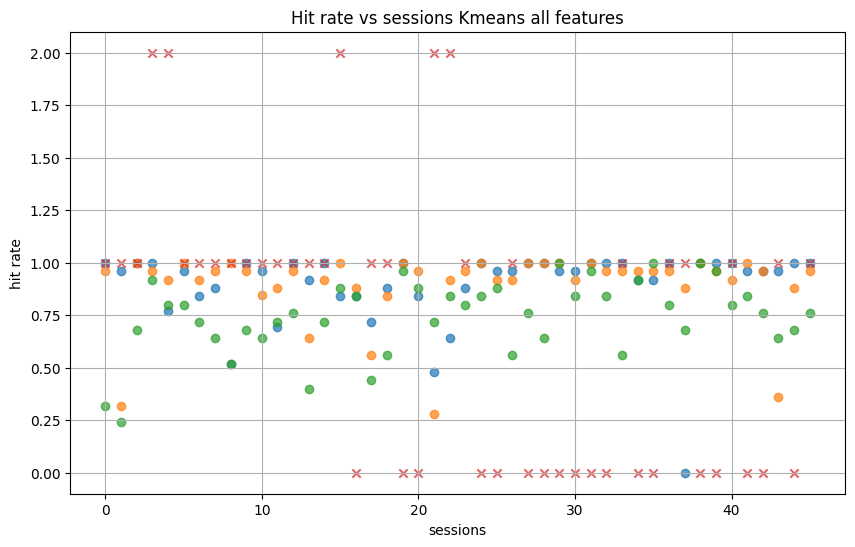

Silhouette Score: 0.5203843445355919


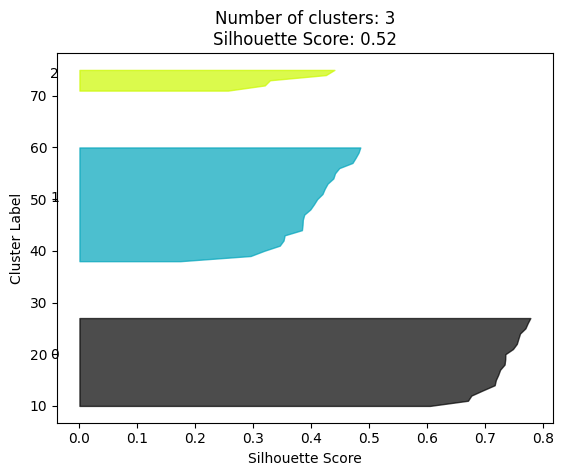

In [76]:
# Transpose the DataFrame to have samples as rows and features as columns
df_transposed = df_imputed.T

# Specify the number of clusters (k)
# num_clusters = 3

# Instantiate the KMeans model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to your data
clusters_km_impute = kmeans_model.fit_predict(df_transposed)

# Add the cluster labels to the transposed DataFrame
df_transposed['Cluster'] = clusters_km_impute

# Display the DataFrame with cluster labels
# print(df_transposed)    

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(46), all_features.loc[0,:], marker='o', alpha=0.7)
plt.scatter(np.arange(46), all_features.loc[1,:], marker='o', alpha=0.7)
plt.scatter(np.arange(46), all_features.loc[2,:], marker='o', alpha=0.7)
plt.scatter(np.arange(46), clusters_km_impute, marker='x', alpha=0.7)
plt.xlabel('sessions')
plt.ylabel('hit rate')
plt.title('Hit rate vs sessions Kmeans all features')
plt.grid(True)
plt.show()

plot_silhouette(df_transposed, clusters_km_impute)

[5.39701072e-01 1.22611079e-01 9.72494290e-02 6.40987171e-02
 5.08067844e-02 3.76806796e-02 2.69974904e-02 2.23400583e-02
 1.70450046e-02 1.08574500e-02 7.27476928e-03 3.21131624e-03
 7.88777155e-05 4.72731660e-05 1.20540227e-32]
[1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 0 1 1 0 0 2 2 1 0 0 1 0 0 0 0 0 0 1 0 0 1
 1 0 0 1 0 0 1 0 1]


/home/nayanika/anaconda3/envs/myelin-h/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


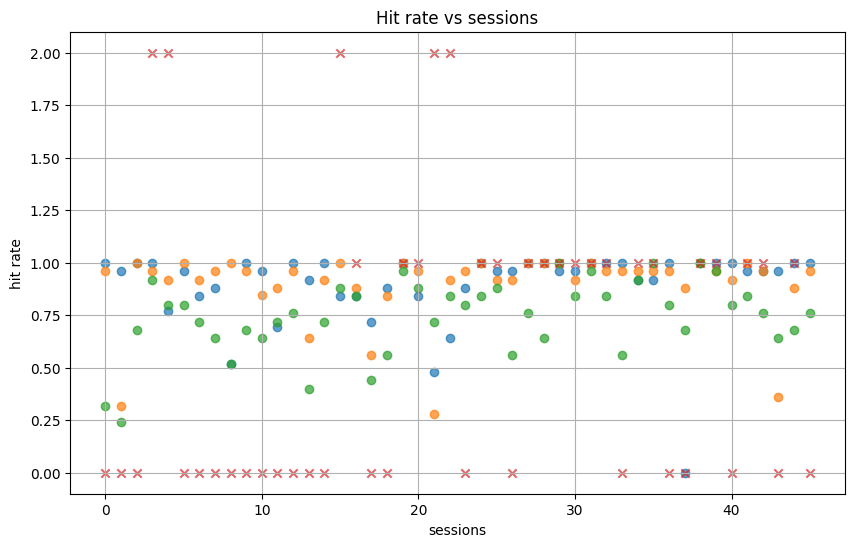

Silhouette Score: 0.5306213124085941


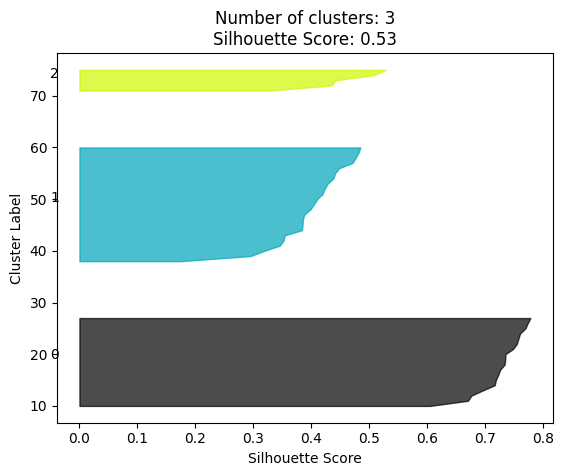

In [79]:
# pca and then k means

from sklearn.decomposition import PCA

# Transpose the DataFrame to have samples as rows and features as columns
df_transposed = df_imputed.T

# Specify the number of principal components
num_components = df_transposed.shape[1]  # Adjust as needed

# Perform PCA
pca = PCA(n_components=num_components)
df_pca = pca.fit_transform(df_transposed)

print(pca.explained_variance_ratio_)
# print(pca.components_)

# Instantiate the KMeans model
num_clusters = 3  # Adjust as needed
kmeans_model = KMeans(n_clusters=num_clusters, random_state=4)

# Fit the KMeans model to the reduced feature space
clusters_km_pca_imputed = kmeans_model.fit_predict(df_pca)

# Add the cluster labels to the transposed DataFrame
df_transposed['Cluster'] = clusters_km_pca_imputed

# Mapping
value_mapping = {2: 2, 1: 0, 0: 1}

# Replace values simultaneously
clusters_km_pca= np.array([value_mapping[value] for value in clusters_km_pca_imputed])

print(clusters_km_pca)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(46), all_features.loc[0,:], marker='o', alpha=0.7)
plt.scatter(np.arange(46), all_features.loc[1,:], marker='o', alpha=0.7)
plt.scatter(np.arange(46), all_features.loc[2,:], marker='o', alpha=0.7)
plt.scatter(np.arange(46), clusters_km_pca_imputed, marker='x', alpha=0.7)
plt.xlabel('sessions')
plt.ylabel('hit rate')
plt.title('Hit rate vs sessions')
plt.grid(True)
plt.show()

plot_silhouette(df_transposed, clusters_km_pca)

# similarity = clusters_km == clusters_km_pca_imputed
# print(f'with kmeans:{sum(similarity)/len(clusters_km)}')
# same_cluster_frequency = np.unique(clusters_km[similarity], return_counts=True)[1]/np.unique(clusters_km, return_counts=True)[1]
# print(same_cluster_frequency)

# similarity = clusters_km_subset1 == clusters_km_pca_imputed
# print(f'with kmeans and subset of features:{sum(similarity)/len(clusters_km_subset1)}')
# same_cluster_frequency = np.unique(clusters_km_subset1[similarity], return_counts=True)[1]/np.unique(clusters_km_subset1, return_counts=True)[1]
# print(same_cluster_frequency)


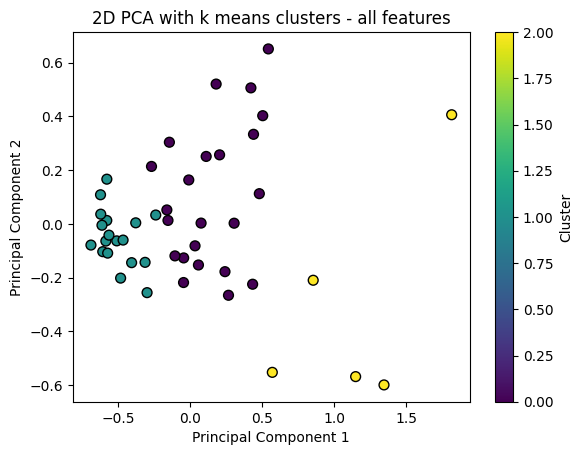

ValueError: 'c' argument has 45 elements, which is inconsistent with 'x' and 'y' with size 46.

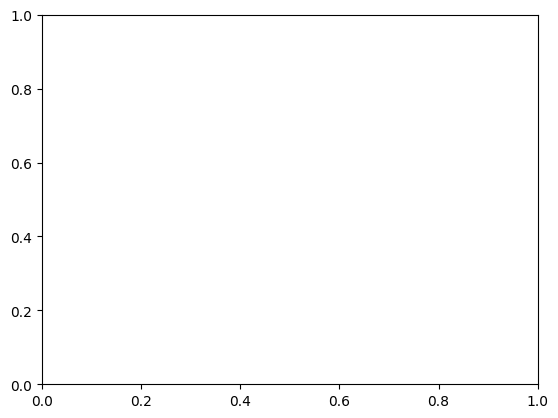

In [81]:
# Create a DataFrame for plotting
plot_PCA = pd.DataFrame({'PC1': df_pca[:, 0], 'PC2': df_pca[:, 1], 'Cluster': clusters_km_pca_imputed})

# Plotting
plt.scatter(plot_PCA['PC1'], plot_PCA['PC2'], c=plot_PCA['Cluster'], cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA with k means clusters - all features')
plt.colorbar(label='Cluster')
plt.show()

# Plotting
plt.scatter(plot_PCA['PC1'], plot_PCA['PC2'], c=clusters_km_subset1, cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA with Cluster Coloring with k means clusters - rates only')
plt.colorbar(label='Cluster')
plt.show()